In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import json
import pickle
import random
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

In [4]:
#Root Directory for FASS Benchmark
BENCH_ROOT = "/content/drive/MyDrive/xai-stability-benchmark"


#Datasets
IMAGENET_DIR = "/content/drive/MyDrive/xai-stability-data/imagenet_1k/data"
COCO_JSON = "/content/drive/MyDrive/xai-stability-data/coco/annotations/instances_train2017_mini.json"
CIFAR_DIR = "/content/drive/MyDrive/xai-stability-data/cifar10/cifar-10-batches-py"


#Target Sample Sizes
IMAGENET_TARGET = 30000
COCO_TARGET = 40000
CIFAR_TARGET = 10000

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Configuration is loaded.")


Configuration is loaded.


In [5]:
folders = [
    "datasets",                 # frozen evaluation subsets
    "dataset_statistics",       # metadata & logs
    "raw_fass_scores",
    "prediction_stability",
    "aggregate_tables",
    "visual_examples/stable",
    "visual_examples/unstable",
    "logs"
]

for folder in folders:
    os.makedirs(os.path.join(BENCH_ROOT, folder), exist_ok=True)

DATASET_DIR = os.path.join(BENCH_ROOT, "datasets")
STAT_DIR = os.path.join(BENCH_ROOT, "dataset_statistics")

print("Benchmark folder structure is ready.")


Benchmark folder structure is ready.


In [7]:
def load_imagenet_sample():

    parquet_files = sorted([
        os.path.join(IMAGENET_DIR, f)
        for f in os.listdir(IMAGENET_DIR)
        if f.endswith(".parquet")
    ])[:10]

    dfs = []

    for pf in tqdm(parquet_files, desc="Reading ImageNet Parquets"):
        df = pd.read_parquet(pf)
        dfs.append(df)

    full_df = pd.concat(dfs, ignore_index=True)
    total_available = len(full_df)

    sample_df = full_df.sample(
        n=min(IMAGENET_TARGET, total_available),
        random_state=SEED
    ).reset_index(drop=True)

    return sample_df, total_available


In [8]:
def load_coco_sample():

    with open(COCO_JSON, 'r') as f:
        data = json.load(f)

    images = data["images"]
    total_available = len(images)

    sample_images = []
    for img in tqdm(
        images[:min(COCO_TARGET, total_available)],
        desc="Selecting COCO Samples"
    ):
        sample_images.append(img)

    return sample_images, total_available


In [9]:
def load_cifar_sample():

    images = []
    labels = []

    for i in tqdm(range(1, 6), desc="Reading CIFAR Batches"):
        with open(os.path.join(CIFAR_DIR, f"data_batch_{i}"), "rb") as f:
            batch = pickle.load(f, encoding="bytes")
            images.append(batch[b"data"])
            labels.extend(batch[b"labels"])

    images = np.vstack(images)
    total_available = len(images)

    images = images[:min(CIFAR_TARGET, total_available)]
    labels = labels[:min(CIFAR_TARGET, total_available)]

    return images, labels, total_available


In [10]:
print("Loading ImageNet sample...")
imagenet_df, imagenet_total = load_imagenet_sample()

print("Loading COCO sample...")
coco_images, coco_total = load_coco_sample()

print("Loading CIFAR sample...")
cifar_images, cifar_labels, cifar_total = load_cifar_sample()

print("Sampling complete.")


Loading ImageNet sample...


Reading ImageNet Parquets: 100%|██████████| 10/10 [05:28<00:00, 32.89s/it]


Loading COCO sample...


Selecting COCO Samples: 100%|██████████| 40000/40000 [00:00<00:00, 4432905.12it/s]


Loading CIFAR sample...


Reading CIFAR Batches: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]

Sampling complete.


In [19]:
# Flatten nested image column
imagenet_df_flat = imagenet_df.copy()

imagenet_df_flat["image_bytes"] = imagenet_df_flat["image"].apply(lambda x: x["bytes"])
imagenet_df_flat = imagenet_df_flat.drop(columns=["image"])

imagenet_df_flat.to_parquet(imagenet_path)

print("Saved flattened ImageNet sample.")


Saved flattened ImageNet sample.


In [20]:
imagenet_path = os.path.join(DATASET_DIR, "imagenet_sample.parquet")
imagenet_df.to_parquet(imagenet_path)

print("Saved ImageNet sample:")
print(imagenet_path)


Saved ImageNet sample:
/content/drive/MyDrive/xai-stability-benchmark/datasets/imagenet_sample.parquet


In [12]:
coco_path = os.path.join(DATASET_DIR, "coco_sample.json")

with open(coco_path, "w") as f:
    json.dump(coco_images, f)

print("Saved COCO sample:")
print(coco_path)


Saved COCO sample:
/content/drive/MyDrive/xai-stability-benchmark/datasets/coco_sample.json


In [13]:
cifar_path = os.path.join(DATASET_DIR, "cifar_sample.npz")

np.savez_compressed(
    cifar_path,
    images=cifar_images,
    labels=cifar_labels
)

print("Saved CIFAR sample:")
print(cifar_path)


Saved CIFAR sample:
/content/drive/MyDrive/xai-stability-benchmark/datasets/cifar_sample.npz


In [14]:
dataset_stats = {
    "imagenet_total_available_in_10_parquets": imagenet_total,
    "imagenet_used": len(imagenet_df),
    "coco_total_available": coco_total,
    "coco_used": len(coco_images),
    "cifar_total_available": cifar_total,
    "cifar_used": len(cifar_images),
    "total_images_used":
        len(imagenet_df) +
        len(coco_images) +
        len(cifar_images)
}

stats_df = pd.DataFrame([dataset_stats])
stats_df


,imagenet_total_available_in_10_parquets,imagenet_used,coco_total_available,coco_used,cifar_total_available,cifar_used,total_images_used
0,35720,30000,45628,40000,50000,10000,80000


In [15]:
stats_path = os.path.join(STAT_DIR, "dataset_summary.csv")
stats_df.to_csv(stats_path, index=False)

print("Saved dataset summary:")
print(stats_path)


Saved dataset summary:
/content/drive/MyDrive/xai-stability-benchmark/dataset_statistics/dataset_summary.csv


In [16]:
metadata = {
    "seed": SEED,
    "imagenet_target": IMAGENET_TARGET,
    "coco_target": COCO_TARGET,
    "cifar_target": CIFAR_TARGET,
    "imagenet_parquets_used": 10,
    "timestamp": str(datetime.now())
}

metadata_path = os.path.join(STAT_DIR, "dataset_config.json")

with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print("Saved configuration metadata:")
print(metadata_path)


Saved configuration metadata:
/content/drive/MyDrive/xai-stability-benchmark/dataset_statistics/dataset_config.json


In [17]:
log_text = f"""
FASS Benchmark Dataset Freeze Log
==================================
Seed: {SEED}

ImageNet:
  Total in 10 parquets: {imagenet_total}
  Used: {len(imagenet_df)}

COCO:
  Total available: {coco_total}
  Used: {len(coco_images)}

CIFAR:
  Total available: {cifar_total}
  Used: {len(cifar_images)}

Total Images Used:
  {dataset_stats['total_images_used']}
"""

log_path = os.path.join(STAT_DIR, "dataset_log.txt")

with open(log_path, "w") as f:
    f.write(log_text)

print("Saved dataset log:")
print(log_path)


Saved dataset log:
/content/drive/MyDrive/xai-stability-benchmark/dataset_statistics/dataset_log.txt


In [14]:
## Saving ImageNet samples so that I can fetch them to train
imagenet_cache_path = os.path.join(
    BENCH_ROOT,
    "dataset_statistics",
    "imagenet_sample_cache.parquet"
)

imagenet_df.to_parquet(imagenet_cache_path)

print("Saved sampled ImageNet dataframe to:")
print(imagenet_cache_path)


Saved sampled ImageNet dataframe to:
/content/drive/MyDrive/xai-stability-benchmark/dataset_statistics/imagenet_sample_cache.parquet


In [23]:
#Saving Coco Samples
coco_path = os.path.join(DATASET_DIR, "coco_sample.json")

with open(coco_path, "w") as f:
    json.dump(coco_images, f)

print("Saved COCO sample:")
print(coco_path)


Saved COCO sample:
/content/drive/MyDrive/xai-stability-benchmark/datasets/coco_sample.json


In [24]:
#Saving CIFAR Samples
cifar_path = os.path.join(DATASET_DIR, "cifar_sample.npz")

np.savez_compressed(
    cifar_path,
    images=cifar_images,
    labels=cifar_labels
)

print("Saved CIFAR sample:")
print(cifar_path)


Saved CIFAR sample:
/content/drive/MyDrive/xai-stability-benchmark/datasets/cifar_sample.npz


##### P.S: I ran a sanity check to ensure my parquet files are properly saved and found that ImageNet files were saved in nested fashion which was weird - So I'm deleting the old parquet, flattening the nested image columns so that all I need (the image bytes) are stored properly in the parquet instead of the nested image column.

In [25]:
import os

imagenet_path = "/content/drive/MyDrive/xai-stability-benchmark/datasets/imagenet_sample.parquet"

if os.path.exists(imagenet_path):
    os.remove(imagenet_path)
    print("Old ImageNet parquet deleted.")
else:
    print("File not found.")


Old ImageNet parquet deleted.


In [26]:
# Flatten nested image column safely
imagenet_df_flat = imagenet_df.copy()

imagenet_df_flat["image_bytes"] = imagenet_df_flat["image"].apply(lambda x: x["bytes"])
imagenet_df_flat = imagenet_df_flat.drop(columns=["image"])

# Save flattened parquet
imagenet_path = "/content/drive/MyDrive/xai-stability-benchmark/datasets/imagenet_sample.parquet"

imagenet_df_flat.to_parquet(imagenet_path, engine="pyarrow")

print("Flattened ImageNet sample saved.")


Flattened ImageNet sample saved.


In [27]:
#Testing to see if my new parquet actually has the image bytes properly saved so that I get only the necessary information I need to process the Image Data which is the image bytes
df_test = pd.read_parquet(imagenet_path)

print(df_test.head())
print(df_test.columns)
print(df_test.shape)


   label                                        image_bytes
0     -1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1     -1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
2     -1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3     -1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
4     -1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
Index(['label', 'image_bytes'], dtype='object')
(30000, 2)


In [28]:
#Checking if the COCO dataset sample is stored properly before I proceed with the training part
coco_path = "/content/drive/MyDrive/xai-stability-benchmark/datasets/coco_sample.json"

import json

with open(coco_path, "r") as f:
    coco_test = json.load(f)

print("Total entries:", len(coco_test))
print("First entry:\n", coco_test[0])


Total entries: 40000
First entry:
 {'license': 4, 'file_name': '000000135116.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000135116.jpg', 'height': 640, 'width': 640, 'date_captured': '2013-11-15 07:41:18', 'flickr_url': 'http://farm5.staticflickr.com/4098/4780185298_7cee5575f2_z.jpg', 'id': 135116}


#### The COCO sample is flat and clean - proceeding to check the CIFAR-10 SAMPLES

In [29]:
cifar_path = "/content/drive/MyDrive/xai-stability-benchmark/datasets/cifar_sample.npz"

import numpy as np

data = np.load(cifar_path)

print("Keys:", data.files)
print("Images shape:", data["images"].shape)
print("Labels shape:", data["labels"].shape)


Keys: ['images', 'labels']
Images shape: (10000, 3072)
Labels shape: (10000,)


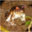

In [31]:
#For sanity check, let's reconstruct one CIFAR-10 iamge before proceeding to the training
from IPython.display import display
from PIL import Image
import numpy as np

data = np.load(cifar_path)

img_flat = data["images"][0]
img = img_flat.reshape(3, 32, 32).transpose(1, 2, 0)

img = img.astype("uint8")

display(Image.fromarray(img))


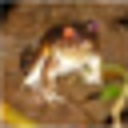

In [32]:
#Ok, this frog looks too small in Colab (CIFAR-10 is just 32x32 in nature). So, let's enlarge it to view properly
display(Image.fromarray(img).resize((128, 128)))


In [33]:
#Good to go!